In [3]:
import kagglehub

dataset_path = kagglehub.dataset_download("ahindoruca/session1")
dataset2_path = kagglehub.dataset_download("ahindoruca/data-v2-aug")

dataset_path

'/kaggle/input/session1'

In [1]:
!pip install ultralytics faster-coco-eval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.6/585.6 kB 31.3 MB/s eta 0:00:00


In [2]:
# Tüm bağımlılıkları uyumlu versiyonlarla kur
!pip install -q --upgrade ultralytics numpy==1.24.3 scipy==1.11.4


  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [4]:
!mkdir /kaggle/working/datav2
!cp -r /kaggle/input/data-v2-aug/data_v2_aug/* /kaggle/working/datav2

In [5]:
!cat /kaggle/working/datav2/data.yaml

names:
- dentigeroz kist
- keratokist
- radikuler kist
- ameloblastoma
- odontoma
nc: 5
path: /Users/sahindogruca/Desktop/code/ytü/semester-7/computerProject2/data/data_v2_aug
test: test/images
train: train/images
val: valid/images


In [6]:
%%writefile /kaggle/working/datav2.yaml
names:
- dentigeroz kist
- keratokist
- radikuler kist
- ameloblastoma
- odontoma
nc: 5
path: /kaggle/working/datav2
test: test/images
train: train/images
val: valid/images

Writing /kaggle/working/datav2.yaml


🚀 Lezyon Boyut Analizi Başlıyor...
📊 Toplam 1661 görüntü analiz edilecek...


Analiz ediliyor: 100%|██████████| 1661/1661 [00:25<00:00, 65.16it/s]



📊 LEZYON BOYUT İSTATİSTİKLERİ

📌 Toplam lezyon sayısı: 2018
📌 Analiz edilen görüntü sayısı: 1661

🏷️  SINIF DAĞILIMI:
----------------------------------------
  Radioopaque: 1080 (53.5%)
  Radiolucent: 938 (46.5%)

📏 BOYUT METRİKLERİ (Piksel):
----------------------------------------
        bbox_width  bbox_height      bbox_area   polygon_area     diagonal
count  2018.000000  2018.000000    2018.000000    2018.000000  2018.000000
mean    173.619377   153.888318   37707.044949   25587.986873   235.057298
std     135.660951   101.669655   60467.522442   38352.080800   165.267281
min      21.000124    23.999816     546.007046     409.006672    33.421769
25%      84.001020    81.000010    6960.640951    4867.346255   119.917286
50%     133.500282   127.999751   17180.870254   12300.117475   189.669462
75%     220.999750   194.999250   42884.458786   30464.406289   300.191034
max    1330.000140   807.000420  609175.036887  331737.836258  1351.480964

📊 ORTALAMA DEĞERLER:
-----------------

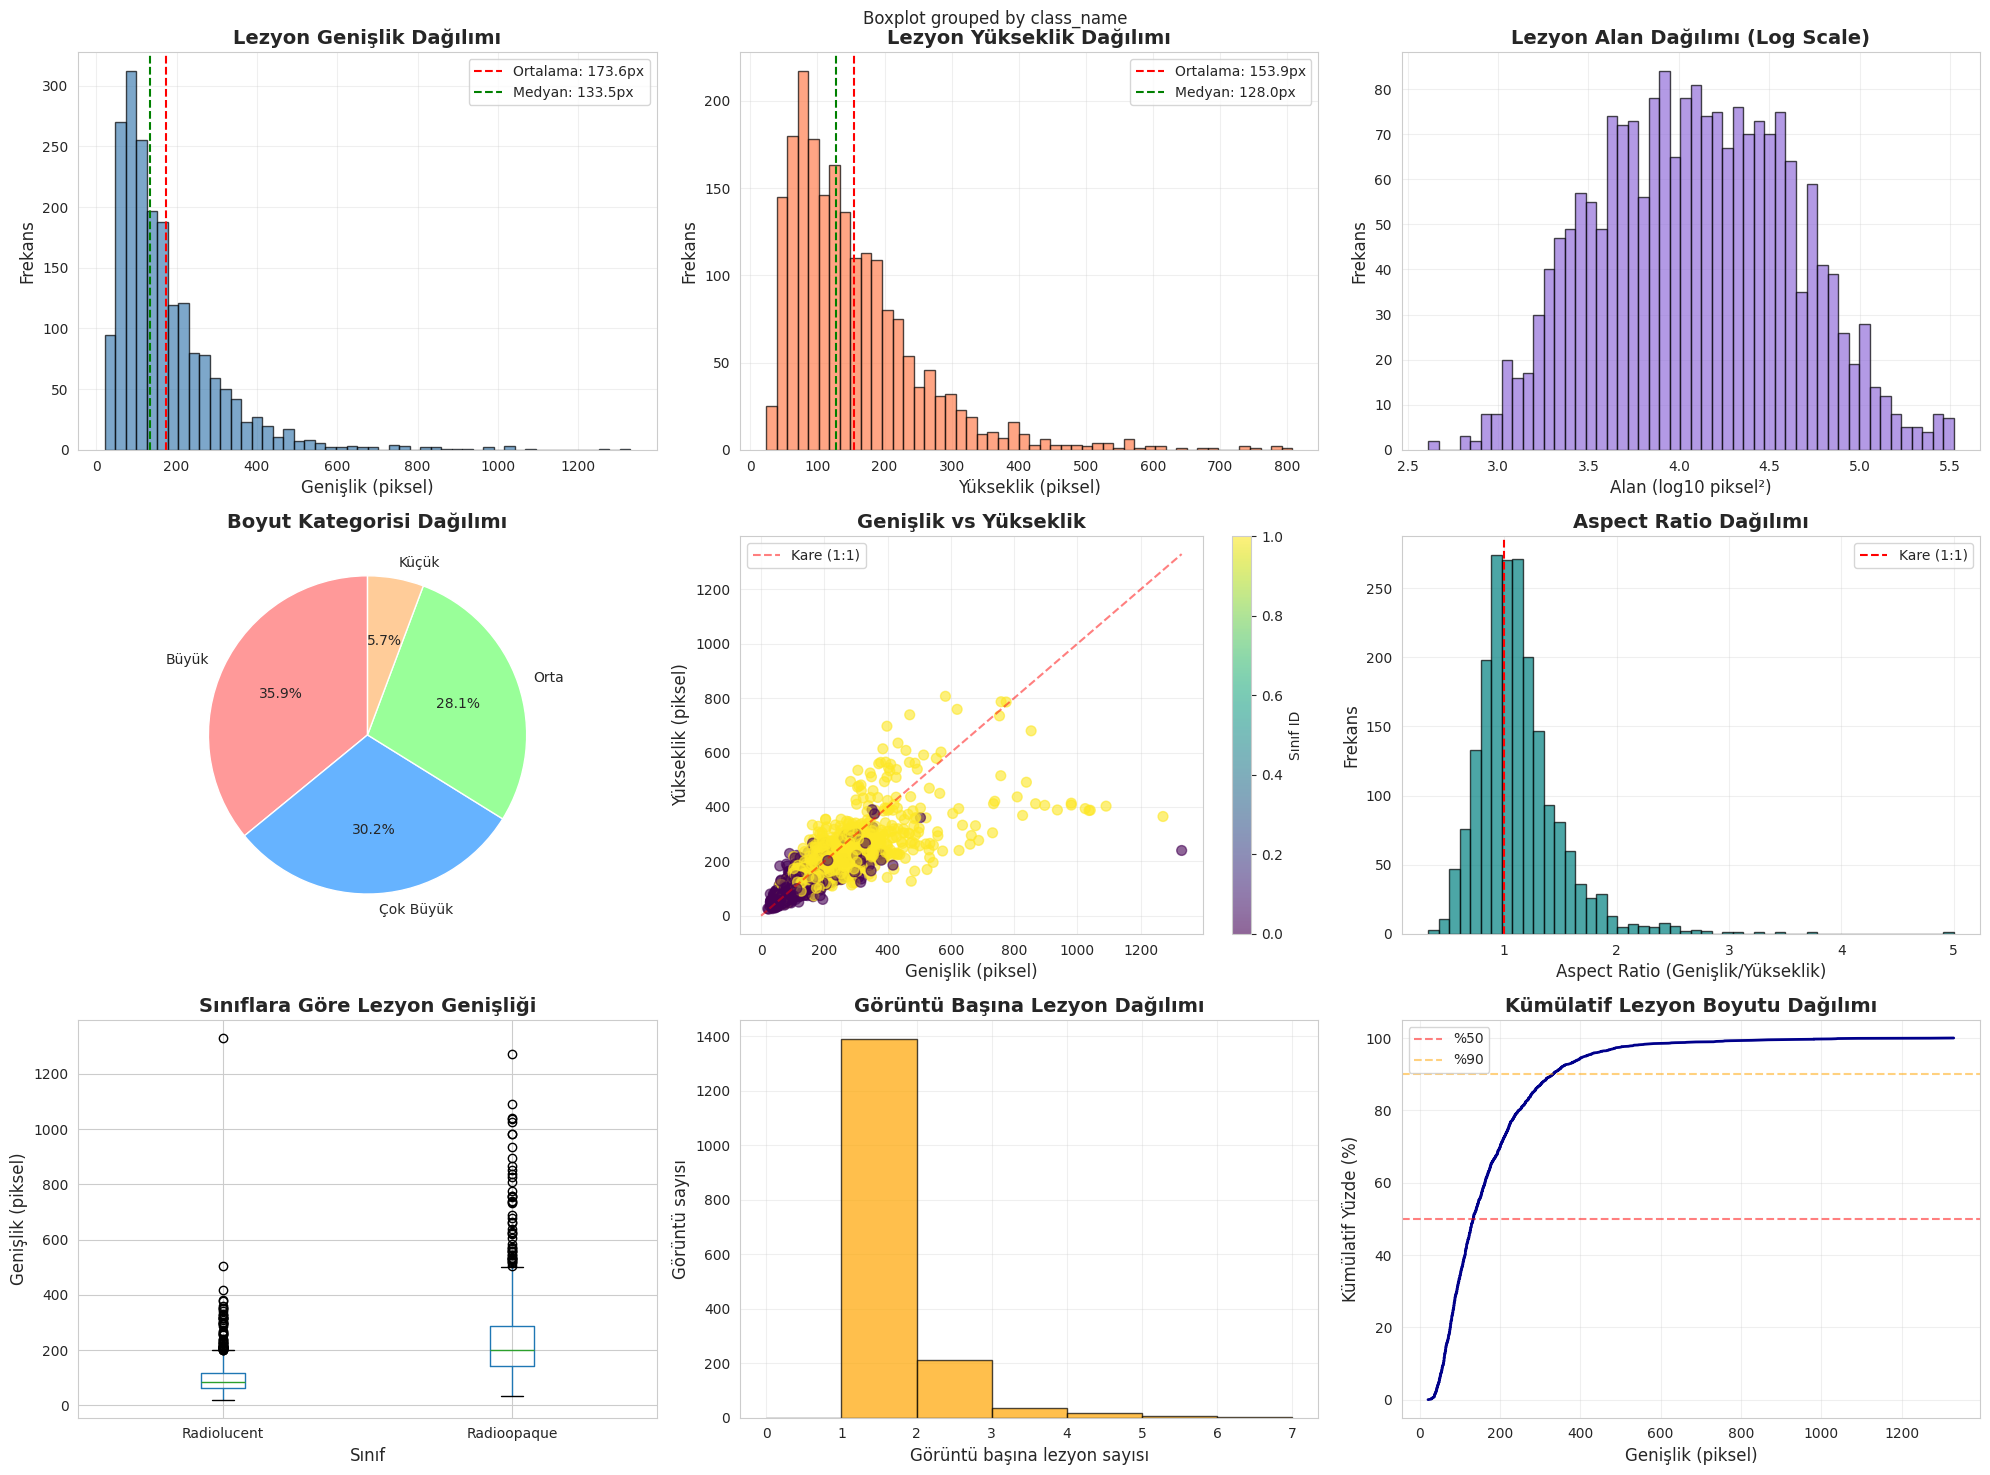


✅ Grafikler 'lezyon_boyut_analizi.png' olarak kaydedildi!

🔬 Her kategoriden örnek lezyonlar gösteriliyor...

🔬 KATEGORİ: Büyük
   Toplam 725 lezyon


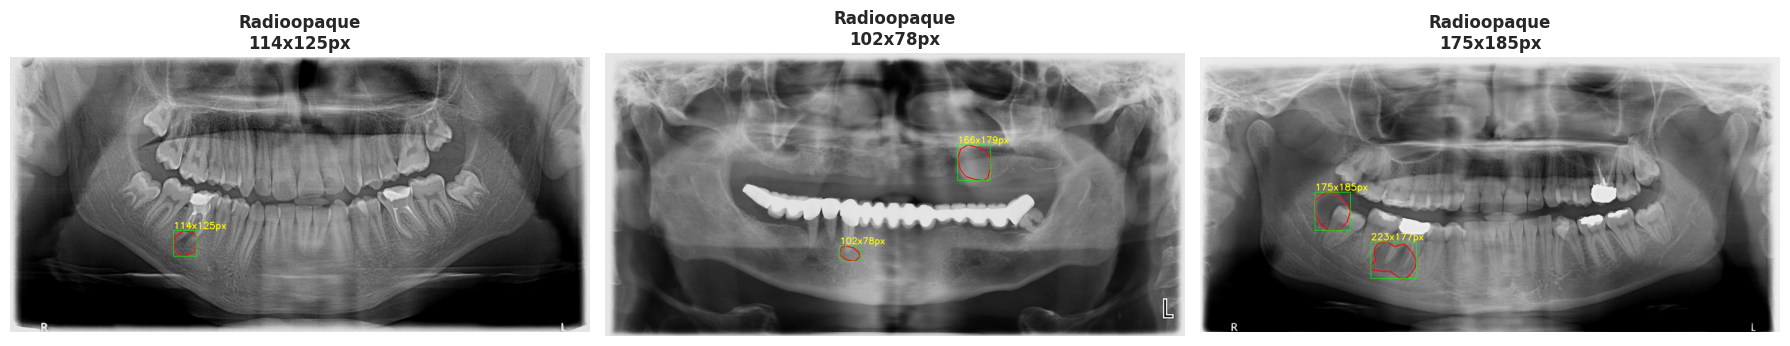


🔬 KATEGORİ: Küçük
   Toplam 115 lezyon


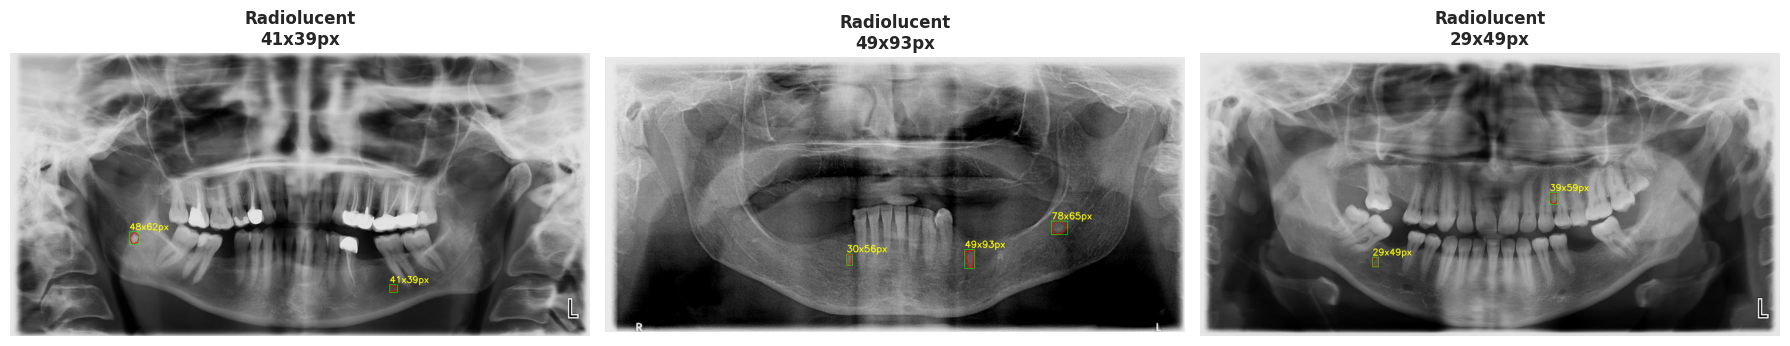


🔬 KATEGORİ: Orta
   Toplam 568 lezyon


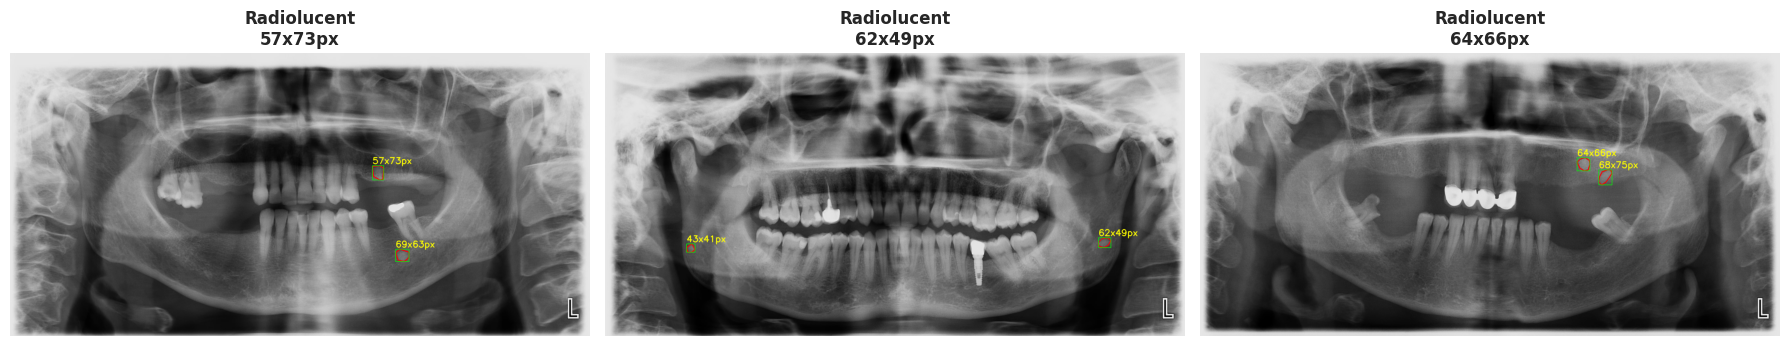


🔬 KATEGORİ: Çok Büyük
   Toplam 610 lezyon


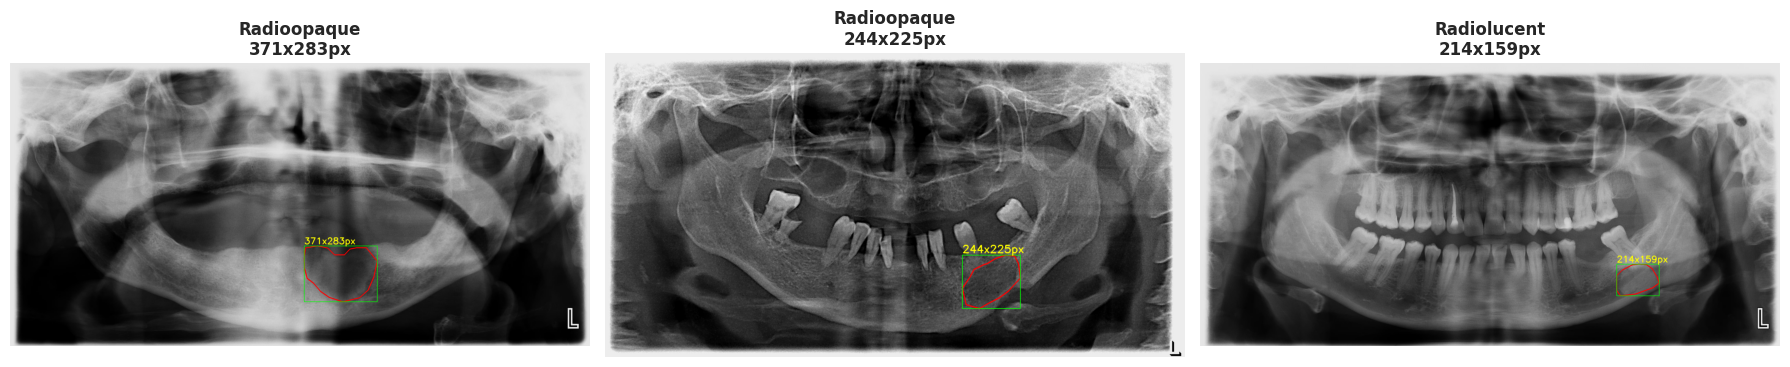


💾 Detaylı rapor 'lezyon_analiz_raporu.csv' olarak kaydedildi!
💾 Özet istatistikler 'lezyon_ozet_istatistik.csv' olarak kaydedildi!

✅ ANALİZ TAMAMLANDI!

📌 ÖNEMLİ BULGULAR:
  • En küçük lezyon: 21.0 piksel
  • En büyük lezyon: 1330.0 piksel
  • Lezyonların %50'si: 133.5 pikselden küçük
  • Lezyonların %90'ı: 332.3 pikselden küçük

🎯 IMGSZ ÖNERİSİ:
  ✅ Lezyonlar BÜYÜK. imgsz=1280 yeterli

  Önerilen: imgsz=898


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict

# Seaborn stil ayarları
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# ==================== KONFIGURASYON ====================
# Dataset path'lerini düzenle
DATASET_ROOT = "/kaggle/working/data"  # Ana klasör
IMAGES_PATH = f"{DATASET_ROOT}/train/images"  # Görüntüler
LABELS_PATH = f"{DATASET_ROOT}/train/labels"  # Annotation'lar

# Kategori tanımları (piksel cinsinden)
CATEGORIES = {
    'Çok Küçük': (0, 20),      # 0-20 piksel
    'Küçük': (20, 50),          # 20-50 piksel
    'Orta': (50, 100),          # 50-100 piksel
    'Büyük': (100, 200),        # 100-200 piksel
    'Çok Büyük': (200, float('inf'))  # 200+ piksel
}

# Sınıf isimleri (senin case'inde)
CLASS_NAMES = {
    0: 'Radiolucent',
    1: 'Radioopaque'
}

# ==================== FONKSİYONLAR ====================

def read_yolo_segmentation(label_path, img_width, img_height):
    """
    YOLO segmentasyon formatını oku ve piksel koordinatlarına çevir
    
    Format: class_id x1 y1 x2 y2 x3 y3 ...
    (normalized 0-1 arası değerler)
    """
    lesions = []
    
    if not os.path.exists(label_path):
        return lesions
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        values = line.strip().split()
        if len(values) < 7:  # En az class + 3 nokta (6 koordinat)
            continue
        
        class_id = int(values[0])
        coords = list(map(float, values[1:]))
        
        # Normalized koordinatları piksel koordinatlarına çevir
        points = []
        for i in range(0, len(coords), 2):
            x_norm, y_norm = coords[i], coords[i+1]
            x_pixel = x_norm * img_width
            y_pixel = y_norm * img_height
            points.append([x_pixel, y_pixel])
        
        points = np.array(points)
        lesions.append({
            'class_id': class_id,
            'class_name': CLASS_NAMES.get(class_id, 'Unknown'),
            'polygon': points
        })
    
    return lesions


def calculate_bbox_from_polygon(polygon):
    """Polygon'dan bounding box hesapla"""
    x_coords = polygon[:, 0]
    y_coords = polygon[:, 1]
    
    x_min, x_max = np.min(x_coords), np.max(x_coords)
    y_min, y_max = np.min(y_coords), np.max(y_coords)
    
    width = x_max - x_min
    height = y_max - y_min
    
    return {
        'x_min': x_min,
        'y_min': y_min,
        'x_max': x_max,
        'y_max': y_max,
        'width': width,
        'height': height,
        'bbox_area': width * height
    }


def calculate_polygon_area(polygon):
    """Polygon'un gerçek alanını hesapla (Shoelace formula)"""
    x = polygon[:, 0]
    y = polygon[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))


def get_lesion_size_category(size, metric='width'):
    """Lezyon boyutunu kategorize et"""
    for category, (min_val, max_val) in CATEGORIES.items():
        if min_val <= size < max_val:
            return category
    return 'Tanımsız'


def analyze_dataset(images_path, labels_path, max_images=None):
    """Dataset'teki tüm lezyonları analiz et"""
    
    # Tüm görüntü dosyalarını bul
    image_files = list(Path(images_path).glob("*.jpg")) + \
                  list(Path(images_path).glob("*.png")) + \
                  list(Path(images_path).glob("*.jpeg"))
    
    if max_images:
        image_files = image_files[:max_images]
    
    print(f"📊 Toplam {len(image_files)} görüntü analiz edilecek...")
    
    all_lesions = []
    images_info = []
    
    for img_path in tqdm(image_files, desc="Analiz ediliyor"):
        # Görüntüyü oku
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        
        img_height, img_width = img.shape[:2]
        
        # Karşılık gelen label dosyasını bul
        label_path = Path(labels_path) / (img_path.stem + '.txt')
        
        # Lezyonları oku
        lesions = read_yolo_segmentation(label_path, img_width, img_height)
        
        images_info.append({
            'image_name': img_path.name,
            'width': img_width,
            'height': img_height,
            'num_lesions': len(lesions)
        })
        
        # Her lezyon için detaylı analiz
        for lesion in lesions:
            polygon = lesion['polygon']
            bbox = calculate_bbox_from_polygon(polygon)
            poly_area = calculate_polygon_area(polygon)
            
            # Diagonal boyutu (en geniş uzunluk)
            diagonal = np.sqrt(bbox['width']**2 + bbox['height']**2)
            
            lesion_data = {
                'image_name': img_path.name,
                'class_id': lesion['class_id'],
                'class_name': lesion['class_name'],
                'bbox_width': bbox['width'],
                'bbox_height': bbox['height'],
                'bbox_area': bbox['bbox_area'],
                'polygon_area': poly_area,
                'diagonal': diagonal,
                'aspect_ratio': bbox['width'] / bbox['height'] if bbox['height'] > 0 else 0,
                'num_points': len(polygon)
            }
            
            # Kategori ekle
            lesion_data['size_category_width'] = get_lesion_size_category(bbox['width'], 'width')
            lesion_data['size_category_area'] = get_lesion_size_category(np.sqrt(poly_area), 'area')
            
            all_lesions.append(lesion_data)
    
    return pd.DataFrame(all_lesions), pd.DataFrame(images_info)


def print_statistics(df):
    """İstatistikleri detaylı yazdır"""
    print("\n" + "="*80)
    print("📊 LEZYON BOYUT İSTATİSTİKLERİ")
    print("="*80)
    
    print(f"\n📌 Toplam lezyon sayısı: {len(df)}")
    print(f"📌 Analiz edilen görüntü sayısı: {df['image_name'].nunique()}")
    
    # Sınıf dağılımı
    print("\n🏷️  SINIF DAĞILIMI:")
    print("-" * 40)
    for class_name, count in df['class_name'].value_counts().items():
        percentage = (count / len(df)) * 100
        print(f"  {class_name}: {count} ({percentage:.1f}%)")
    
    # Boyut metrikleri
    metrics = ['bbox_width', 'bbox_height', 'bbox_area', 'polygon_area', 'diagonal']
    
    print("\n📏 BOYUT METRİKLERİ (Piksel):")
    print("-" * 40)
    
    stats_df = df[metrics].describe()
    print(stats_df.to_string())
    
    print("\n📊 ORTALAMA DEĞERLER:")
    print("-" * 40)
    print(f"  Ortalama genişlik: {df['bbox_width'].mean():.2f} piksel")
    print(f"  Ortalama yükseklik: {df['bbox_height'].mean():.2f} piksel")
    print(f"  Ortalama diagonal: {df['diagonal'].mean():.2f} piksel")
    print(f"  Ortalama bbox alan: {df['bbox_area'].mean():.2f} piksel²")
    print(f"  Ortalama polygon alan: {df['polygon_area'].mean():.2f} piksel²")
    print(f"  Ortalama aspect ratio: {df['aspect_ratio'].mean():.2f}")
    
    print("\n📊 MEDYAN DEĞERLER:")
    print("-" * 40)
    print(f"  Medyan genişlik: {df['bbox_width'].median():.2f} piksel")
    print(f"  Medyan yükseklik: {df['bbox_height'].median():.2f} piksel")
    print(f"  Medyan diagonal: {df['diagonal'].median():.2f} piksel")
    
    # Kategori dağılımı
    print("\n📂 BOYUT KATEGORİLERİ (Genişlik bazında):")
    print("-" * 40)
    category_counts = df['size_category_width'].value_counts().sort_index()
    for category, count in category_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {category}: {count} ({percentage:.1f}%)")
    
    print("\n" + "="*80)


def visualize_distributions(df, images_info):
    """Boyut dağılımlarını görselleştir"""
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('🔬 Lezyon Boyut Analizi - Detaylı Görselleştirmeler', 
                 fontsize=20, fontweight='bold')
    
    # 1. Genişlik Histogram
    ax = axes[0, 0]
    ax.hist(df['bbox_width'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(df['bbox_width'].mean(), color='red', linestyle='--', 
               label=f'Ortalama: {df["bbox_width"].mean():.1f}px')
    ax.axvline(df['bbox_width'].median(), color='green', linestyle='--',
               label=f'Medyan: {df["bbox_width"].median():.1f}px')
    ax.set_xlabel('Genişlik (piksel)', fontsize=12)
    ax.set_ylabel('Frekans', fontsize=12)
    ax.set_title('Lezyon Genişlik Dağılımı', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Yükseklik Histogram
    ax = axes[0, 1]
    ax.hist(df['bbox_height'], bins=50, color='coral', alpha=0.7, edgecolor='black')
    ax.axvline(df['bbox_height'].mean(), color='red', linestyle='--',
               label=f'Ortalama: {df["bbox_height"].mean():.1f}px')
    ax.axvline(df['bbox_height'].median(), color='green', linestyle='--',
               label=f'Medyan: {df["bbox_height"].median():.1f}px')
    ax.set_xlabel('Yükseklik (piksel)', fontsize=12)
    ax.set_ylabel('Frekans', fontsize=12)
    ax.set_title('Lezyon Yükseklik Dağılımı', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Alan Histogram (Log scale)
    ax = axes[0, 2]
    ax.hist(np.log10(df['polygon_area'] + 1), bins=50, color='mediumpurple', 
            alpha=0.7, edgecolor='black')
    ax.set_xlabel('Alan (log10 piksel²)', fontsize=12)
    ax.set_ylabel('Frekans', fontsize=12)
    ax.set_title('Lezyon Alan Dağılımı (Log Scale)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 4. Boyut Kategorileri (Pie Chart)
    ax = axes[1, 0]
    category_counts = df['size_category_width'].value_counts()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
    ax.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
           colors=colors, startangle=90)
    ax.set_title('Boyut Kategorisi Dağılımı', fontsize=14, fontweight='bold')
    
    # 5. Genişlik vs Yükseklik Scatter
    ax = axes[1, 1]
    scatter = ax.scatter(df['bbox_width'], df['bbox_height'], 
                        c=df['class_id'], cmap='viridis', alpha=0.6, s=50)
    ax.plot([0, df['bbox_width'].max()], [0, df['bbox_width'].max()], 
            'r--', alpha=0.5, label='Kare (1:1)')
    ax.set_xlabel('Genişlik (piksel)', fontsize=12)
    ax.set_ylabel('Yükseklik (piksel)', fontsize=12)
    ax.set_title('Genişlik vs Yükseklik', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Sınıf ID')
    
    # 6. Aspect Ratio Dağılımı
    ax = axes[1, 2]
    ax.hist(df['aspect_ratio'].clip(0, 5), bins=50, color='teal', alpha=0.7, edgecolor='black')
    ax.axvline(1.0, color='red', linestyle='--', label='Kare (1:1)')
    ax.set_xlabel('Aspect Ratio (Genişlik/Yükseklik)', fontsize=12)
    ax.set_ylabel('Frekans', fontsize=12)
    ax.set_title('Aspect Ratio Dağılımı', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 7. Box Plot - Sınıflara göre genişlik
    ax = axes[2, 0]
    df.boxplot(column='bbox_width', by='class_name', ax=ax)
    ax.set_xlabel('Sınıf', fontsize=12)
    ax.set_ylabel('Genişlik (piksel)', fontsize=12)
    ax.set_title('Sınıflara Göre Lezyon Genişliği', fontsize=14, fontweight='bold')
    plt.sca(ax)
    plt.xticks(rotation=0)
    
    # 8. Görüntü başına lezyon sayısı
    ax = axes[2, 1]
    ax.hist(images_info['num_lesions'], bins=range(0, images_info['num_lesions'].max()+2),
            color='orange', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Görüntü başına lezyon sayısı', fontsize=12)
    ax.set_ylabel('Görüntü sayısı', fontsize=12)
    ax.set_title('Görüntü Başına Lezyon Dağılımı', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 9. Kümülatif dağılım
    ax = axes[2, 2]
    sorted_widths = np.sort(df['bbox_width'])
    cumulative = np.arange(1, len(sorted_widths) + 1) / len(sorted_widths) * 100
    ax.plot(sorted_widths, cumulative, linewidth=2, color='darkblue')
    ax.axhline(50, color='red', linestyle='--', alpha=0.5, label='%50')
    ax.axhline(90, color='orange', linestyle='--', alpha=0.5, label='%90')
    ax.set_xlabel('Genişlik (piksel)', fontsize=12)
    ax.set_ylabel('Kümülatif Yüzde (%)', fontsize=12)
    ax.set_title('Kümülatif Lezyon Boyutu Dağılımı', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('lezyon_boyut_analizi.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Grafikler 'lezyon_boyut_analizi.png' olarak kaydedildi!")


def show_example_lesions(df, images_path, labels_path, num_examples=3):
    """Her kategoriden örnek lezyonları göster"""
    
    categories = df['size_category_width'].unique()
    
    for category in sorted(categories):
        category_df = df[df['size_category_width'] == category]
        
        if len(category_df) == 0:
            continue
        
        print(f"\n{'='*80}")
        print(f"🔬 KATEGORİ: {category}")
        print(f"   Toplam {len(category_df)} lezyon")
        print('='*80)
        
        # Rastgele örnekler seç
        samples = category_df.sample(min(num_examples, len(category_df)))
        
        fig, axes = plt.subplots(1, len(samples), figsize=(6*len(samples), 6))
        if len(samples) == 1:
            axes = [axes]
        
        for idx, (_, lesion) in enumerate(samples.iterrows()):
            # Görüntüyü yükle
            img_path = Path(images_path) / lesion['image_name']
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Label dosyasını oku
            label_path = Path(labels_path) / (Path(lesion['image_name']).stem + '.txt')
            lesions = read_yolo_segmentation(label_path, img.shape[1], img.shape[0])
            
            # Lezyonu çiz
            for les in lesions:
                # Polygon çiz
                pts = les['polygon'].astype(np.int32)
                cv2.polylines(img, [pts], True, (255, 0, 0), 3)
                
                # Bounding box çiz
                bbox = calculate_bbox_from_polygon(les['polygon'])
                cv2.rectangle(img, 
                            (int(bbox['x_min']), int(bbox['y_min'])),
                            (int(bbox['x_max']), int(bbox['y_max'])),
                            (0, 255, 0), 2)
                
                # Boyut bilgisi ekle
                text = f"{bbox['width']:.0f}x{bbox['height']:.0f}px"
                cv2.putText(img, text, 
                          (int(bbox['x_min']), int(bbox['y_min']-10)),
                          cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 0), 3)
            
            axes[idx].imshow(img)
            axes[idx].set_title(f"{lesion['class_name']}\n{lesion['bbox_width']:.0f}x{lesion['bbox_height']:.0f}px", 
                              fontsize=12, fontweight='bold')
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'ornekler_{category.replace(" ", "_")}.png', dpi=150, bbox_inches='tight')
        plt.show()


def save_report(df, images_info, output_path='lezyon_analiz_raporu.csv'):
    """Detaylı raporu CSV olarak kaydet"""
    
    # Ana dataframe'i kaydet
    df.to_csv(output_path, index=False)
    print(f"\n💾 Detaylı rapor '{output_path}' olarak kaydedildi!")
    
    # Özet istatistikler
    summary = {
        'Toplam_Lezyon': len(df),
        'Toplam_Goruntu': df['image_name'].nunique(),
        'Ortalama_Genislik': df['bbox_width'].mean(),
        'Ortalama_Yukseklik': df['bbox_height'].mean(),
        'Ortalama_Alan': df['polygon_area'].mean(),
        'Medyan_Genislik': df['bbox_width'].median(),
        'Medyan_Yukseklik': df['bbox_height'].median(),
    }
    
    summary_df = pd.DataFrame([summary])
    summary_df.to_csv('lezyon_ozet_istatistik.csv', index=False)
    print(f"💾 Özet istatistikler 'lezyon_ozet_istatistik.csv' olarak kaydedildi!")


# ==================== ANA ÇALIŞTIRMA ====================

if __name__ == "__main__":
    print("🚀 Lezyon Boyut Analizi Başlıyor...")
    print("="*80)
    
    # Dataset'i analiz et
    lesions_df, images_df = analyze_dataset(IMAGES_PATH, LABELS_PATH)
    
    # İstatistikleri yazdır
    print_statistics(lesions_df)
    
    # Görselleştirmeler
    print("\n📊 Görselleştirmeler oluşturuluyor...")
    visualize_distributions(lesions_df, images_df)
    
    # Örnek lezyonlar
    print("\n🔬 Her kategoriden örnek lezyonlar gösteriliyor...")
    show_example_lesions(lesions_df, IMAGES_PATH, LABELS_PATH, num_examples=3)
    
    # Rapor kaydet
    save_report(lesions_df, images_df)
    
    print("\n" + "="*80)
    print("✅ ANALİZ TAMAMLANDI!")
    print("="*80)
    
    # Önemli bilgiler
    print("\n📌 ÖNEMLİ BULGULAR:")
    print(f"  • En küçük lezyon: {lesions_df['bbox_width'].min():.1f} piksel")
    print(f"  • En büyük lezyon: {lesions_df['bbox_width'].max():.1f} piksel")
    print(f"  • Lezyonların %50'si: {lesions_df['bbox_width'].quantile(0.5):.1f} pikselden küçük")
    print(f"  • Lezyonların %90'ı: {lesions_df['bbox_width'].quantile(0.9):.1f} pikselden küçük")
    
    # imgsz önerisi
    print("\n🎯 IMGSZ ÖNERİSİ:")
    median_width = lesions_df['bbox_width'].median()
    
    if median_width < 30:
        print("  ⚠️  Lezyonlar KÜÇÜK! imgsz=1920 veya 2048 kullan")
    elif median_width < 60:
        print("  ✅ Lezyonlar ORTA boyutta. imgsz=1536 optimal")
    else:
        print("  ✅ Lezyonlar BÜYÜK. imgsz=1280 yeterli")
    
    print(f"\n  Önerilen: imgsz={int(3000 * (40 / median_width))}")

In [7]:
import torch
print(f"GPU Allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")
print(f"GPU Reserved: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")
print(f"GPU Free: {torch.cuda.get_device_properties(0).total_memory/1024**3 - torch.cuda.memory_allocated(0)/1024**3:.2f} GB")


GPU Allocated: 0.21 GB
GPU Reserved: 3.84 GB
GPU Free: 15.67 GB


In [11]:
from ultralytics import YOLO

model = YOLO("/kaggle/working/runs/train/yolov8x-seg-datav2/weights/best.pt")

results = model.train(
    data="/kaggle/working/datav2.yaml",
    epochs=60,
    resume=False,
    cache='ram',
    workers=2,
    pretrained=True,
    imgsz=1408,
    device=0,
    patience=25,
    batch=8,
    save_period=10,
    project='runs/train',
    name='yolov8x-seg-datav2-finetune',
    exist_ok=True,
    verbose=True,
    single_cls=False,
    optimizer='AdamW',
    lr0=0.0005,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    cos_lr=True,
    amp=True,
    plots=True,
    visualize=False,
    cls=0.75,
    hsv_h=0.01,          # ⬆️ 0.005→0.01: Büyük objeler için biraz artırıldı
    hsv_s=0.15,          # ⬆️ 0.1→0.15
    hsv_v=0.25,          # ⬆️ 0.2→0.25
    degrees=5.0,         # ⬆️ 3→5: Büyük objeler rotasyona daha dayanıklı
    translate=0.15,
    scale=0.1,           
    shear=0.0,
    flipud=0.0,
    fliplr=0.5,
    mosaic=0.0,          # ⬆️ 0.8→0.9: Büyük objeler mosaic'te iyi çalışır
    close_mosaic=30,     # ⬆️ 25→30
    mixup=0.1,           # ⬆️ 0.05→0.1: Büyük objeler için güvenli
    copy_paste=0.2,      # ⬆️ 0.1→0.2: Büyük lezyonlar kopyalanabilir
    rect=True,
    
)

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=30, cls=0.75, compile=False, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/datav2.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.15, hsv_v=0.25, imgsz=1408, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=/kaggle/working/runs/train/yolov8x-seg-datav2/weights/best.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=yolov8x-seg-datav2-finetune, nbs=64, nms=False, opset=None, optimize=False, opt

In [13]:
from ultralytics import YOLO
model = YOLO("/kaggle/working/runs/train/yolov8x-seg-datav2/weights/best.pt")

model.val(
    data="/kaggle/working/datav2.yaml",
    imgsz=1536,
    batch=4,
    save_json=True,
    plots=True,
    split='test',
    visualize=True,
    verbose=True,
    project='runs/test',
    name='yolov8x-seg-datav2-finetune'
    
)



Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8l-seg summary (fused): 125 layers, 45,915,743 parameters, 0 gradients, 210.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2547.8±613.1 MB/s, size: 3003.3 KB)
val: Scanning /kaggle/working/datav2/test/labels.cache... 98 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 98/98 224.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 1.4it/s 17.9s0.8s
                   all         98        103      0.804      0.653      0.743      0.498      0.804      0.653      0.743      0.485
       dentigeroz kist         23         24      0.674      0.691      0.727      0.521      0.674      0.691      0.727      0.487
            keratokist         19         19      0.581      0.474      0.554      0.334      0.581      0.474      0.554       0.34
        radikuler k

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x782b4e4bbb90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,  